In [1]:
#Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

#Set some global defaults
sns.set(rc={"figure.figsize": (15, 8), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes',  labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes',  titlesize=18)                                  # fontsize of the tick labels
pd.set_option('max_columns', 100)                              # Its nice to see all columns

-------------------

This notebook will explore the NFL Combine data in a more rigorous way: using inferential statistics. First of course, we need to read in the cleaned dataset we created in the data wrangling step.

In [2]:
df = pd.read_pickle('cleaned_df.pkl')
df['round'] = df['round'].astype(int)
df['year'] = df['year'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6013 entries, 0 to 6012
Data columns (total 21 columns):
name             6013 non-null object
year             6013 non-null int64
college          5705 non-null object
position         6013 non-null object
height           6013 non-null float64
weight           6013 non-null float64
fortyyd          6013 non-null float64
vertical         6013 non-null float64
bench            6013 non-null float64
threecone        6013 non-null float64
shuttle          6013 non-null float64
broad            6013 non-null float64
wonderlic        6013 non-null float64
nflgrade         6013 non-null float64
arms             6013 non-null float64
hands            6013 non-null float64
team             3829 non-null object
round            6013 non-null int64
pick             6013 non-null float64
overall          6013 non-null float64
positiongroup    6013 non-null object
dtypes: float64(14), int64(2), object(5)
memory usage: 1.0+ MB


In the last notebook, the data story, we explored QBs in the dataset. So let's first make the same dataset. 

In [3]:
qb = df[df.position == 'QB']

Next, we can remember that at the end of that data story notebook we took a look at two jointplots. These jointplots look at the draft **round** vs **broad** jump and **shuttle** run, respectively. For reference, we can plot these jointplots again below. 

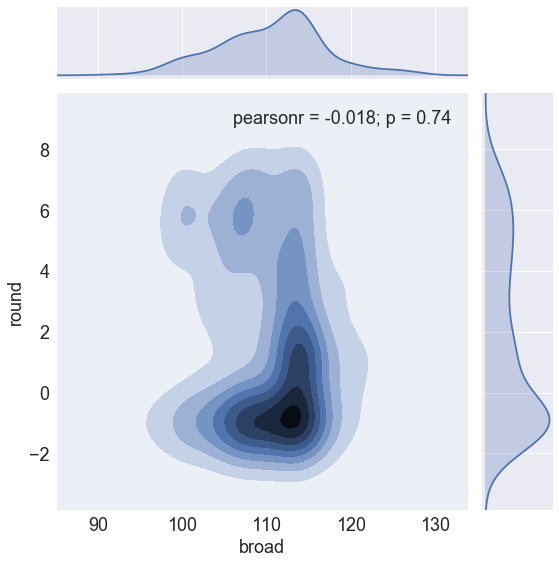

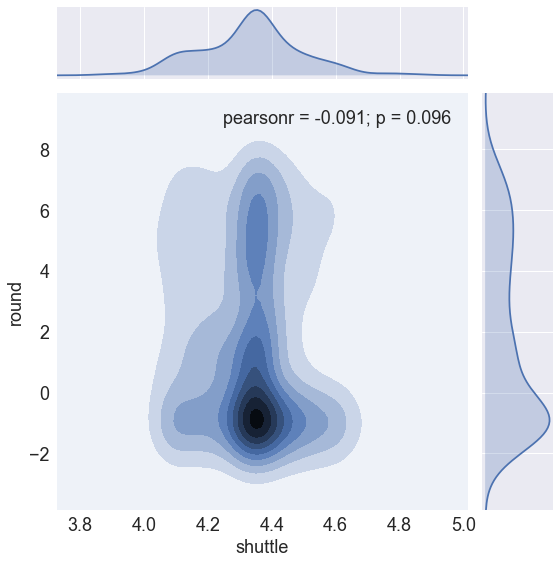

In [4]:
sns.jointplot(x='broad'  , y='round', data=qb, kind='kde', size=8)
plt.show()
sns.jointplot(x='shuttle', y='round', data=qb, kind='kde', size=8)
plt.show()

At the time, there was a promise that we would look into the correlation between the draft **round** and the other variable of interest. So let's look into some of the issues we face here:
- Is the Pearson correlation coefficient an appropriate metric to use for correlation?
- Can we trust the p-value for the correlation coefficient? 

The draft **round** is our target variable but it is also, in spirit, a categorical variable, not continuous. So we have to be careful when dealing with it. The usual correlation calculation is the Pearson correlation coefficient which does not really apply to categorical variables. Instead we will use the Kendall rank correlation coefficient, which should deal better with the situation at hand. Because the draft **round** can be thought of as ordinal, this rank correlation is well suited for us. 

After calculating the (Kendall) correlation, we can also compute its p-value. If we assume an $\alpha$, or statistical significance, level of 5%, then any p-value below 0.05 should be significant. The null hypothesis in this case is that there is no correlation between the two variables being tested. So a low p-value signals the calculated correlation is significant. However, in order to really trust the result of this test we can perform a permutation test of the correlation. This permutation test randomly exchanges the draft **round** labels and re-calculates the correlation. We can then calculate the p-value by comparing how many permuted correlations are larger than the observed correlation. 

We can now perform these tests for the 12 variables of interest against the draft **round**. These columns are listed below.

In [5]:
cols_to_view = [u'height', u'weight', u'fortyyd', u'vertical', u'bench', u'threecone', u'shuttle', u'broad',
                u'wonderlic', u'nflgrade', u'arms', u'hands']

The following loop will go through the entire list and output the observed correlation (in red) and estimated correlation (the histogram) as well as the observed and estimated p-values (outside the plot). 

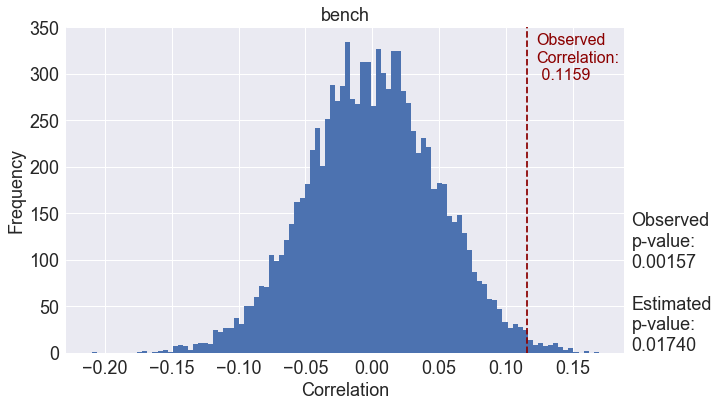

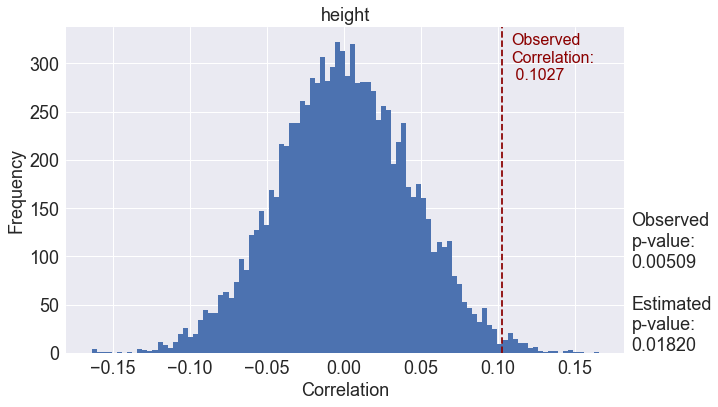

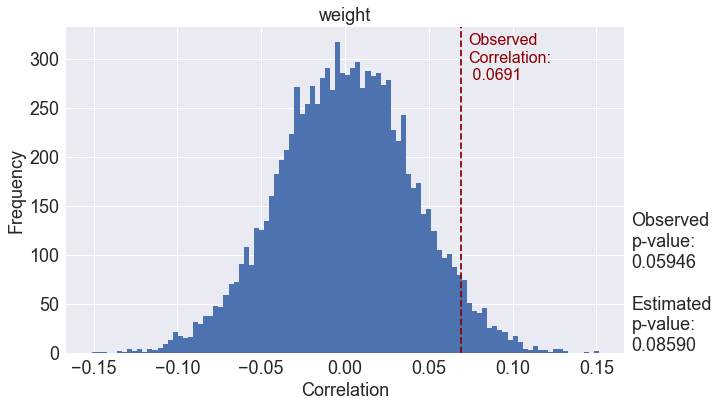

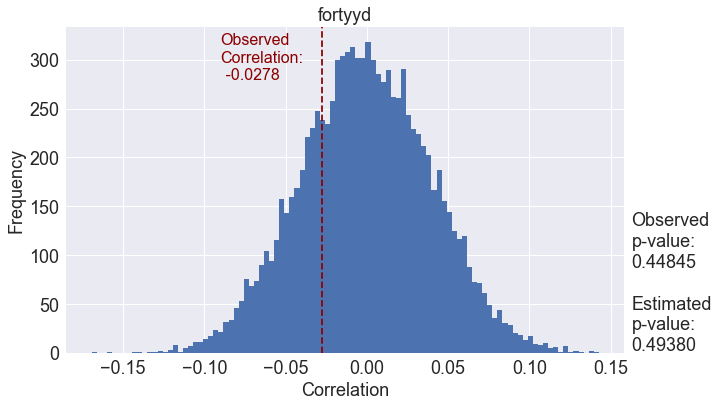

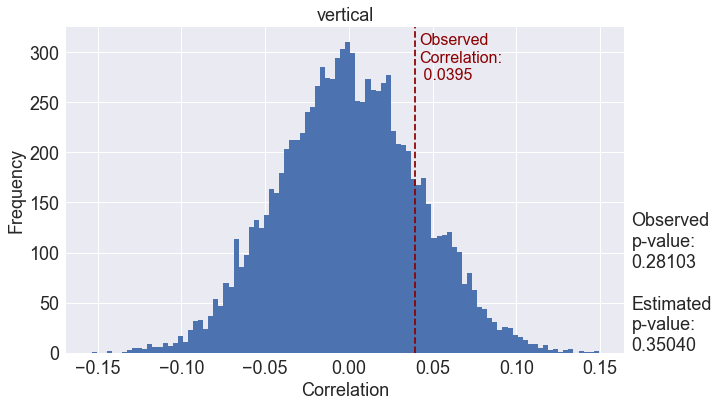

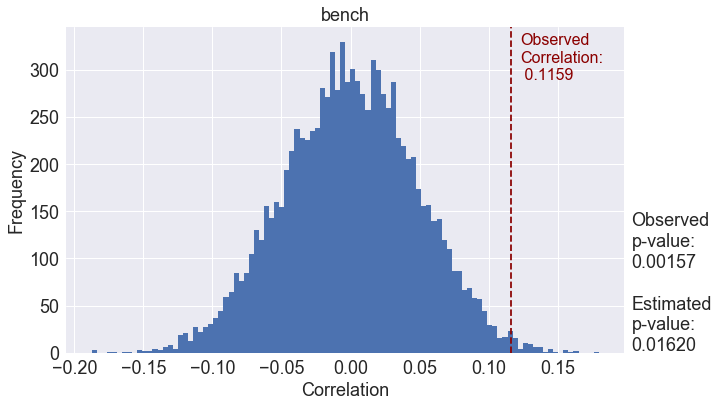

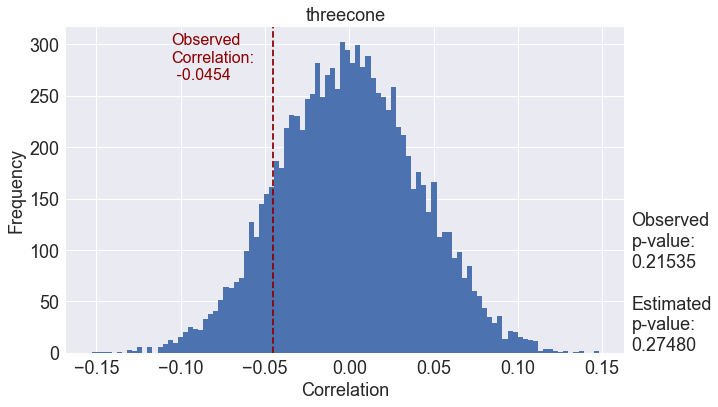

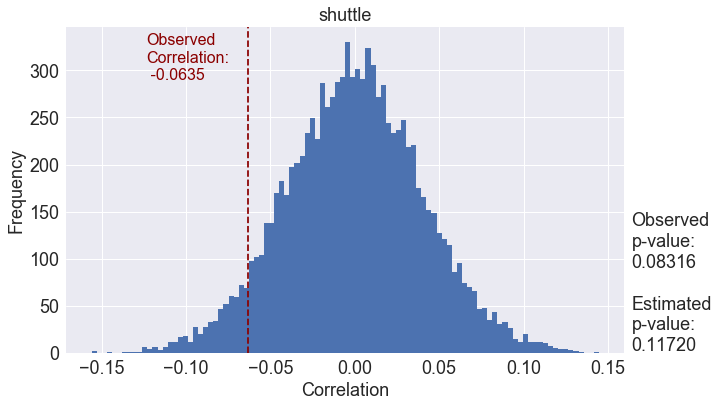

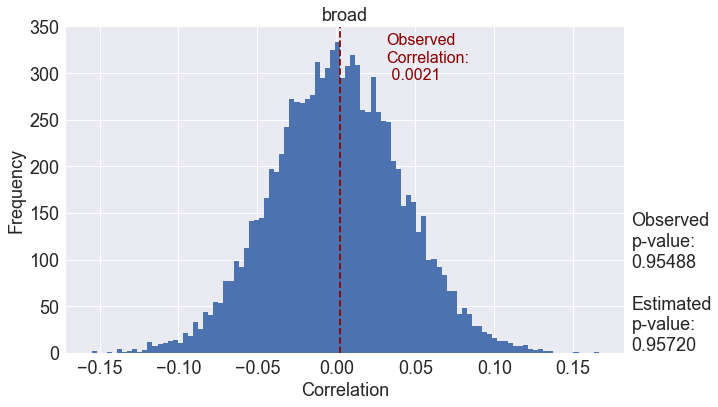

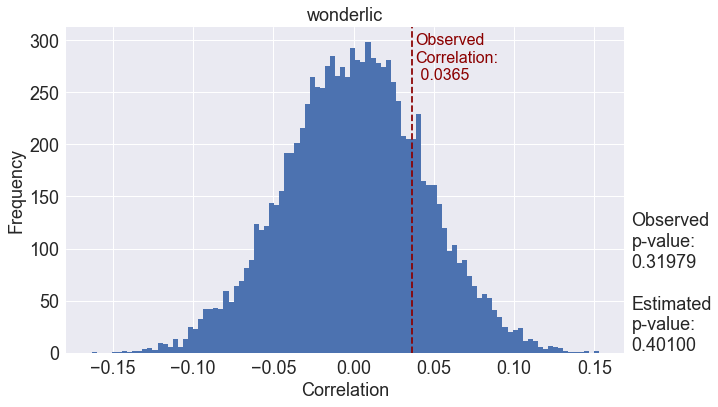

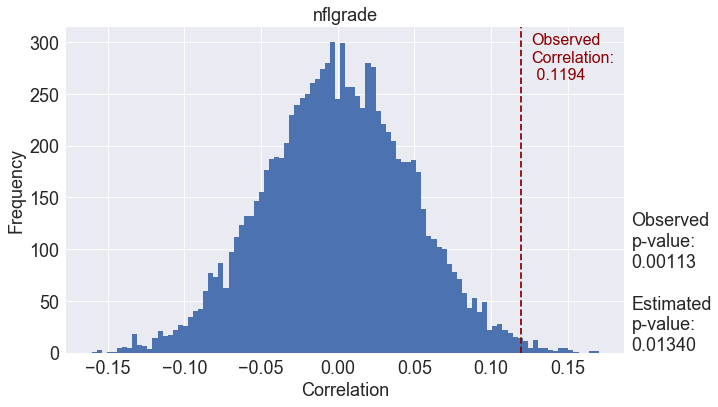

In [ ]:
#Save output of the correlation tests
corr_res = pd.DataFrame(index=cols_to_view, columns=['correlation','p_val_obs','p_val_est'])
corr_res.fillna(0)

for col in cols_to_view:
    
    #Get correlation coefficient (Kendall)
    corr_obs, p_val_obs = stats.kendalltau(qb['round'], qb[col])
    ##corr_obs, p_val_obs = stats.pearsonr(qb['round'], qb[col]) #for pearson

    #Initialize permutation replicates (10k)
    perm_replicates = np.empty(10000)

    #Draw the permuted replicates
    for i in range(10000):
        
        #Permute the draft rounds
        col_permuted = np.random.permutation(qb['round'])

        #Compute correlation for the permutated col
        perm_replicates[i], _ = stats.kendalltau(col_permuted, qb[col])
        ##perm_replicates[i], _ = stats.pearsonr(col_permuted, qb[col]) #for pearson


    #Compute p-value from permutation
    p_val_est = np.sum(np.abs(perm_replicates) >= np.abs(corr_obs))*1. / len(perm_replicates) #two-tailed
    
    #Save to output df
    corr_res.loc[col,'correlation'] = corr_obs
    corr_res.loc[col,'p_val_obs'  ] = p_val_obs
    corr_res.loc[col,'p_val_est'  ] = p_val_est
    
    #Plot histogram of the results of the permutation
    plt.figure(figsize=(10,6))
    
    #Add text/line for the observed correlation by first doing rough calculation for where to print correlation info
    ybins, xbins, _ = plt.hist(perm_replicates, bins=100)
    corr_plot = corr_obs
    if abs(corr_plot) < 0.03:
        if corr_plot < 0:
            corr_plot = -0.03
        else:
            corr_plot = 0.03
    text_x = corr_plot * 1.06 if corr_plot > 0 else corr_plot - 0.06
    text_y = ybins.max()*0.88
    plt.text(text_x, text_y, 'Observed\nCorrelation:\n %0.4f' % corr_obs, fontsize=16, color='darkred')
    plt.axvline(corr_obs, color = 'darkred', ls = '--')
    #Add text for p-value info outside the plot
    plt.gcf().text(0.91, 0.13, 'Observed\np-value:\n%.5f\n\nEstimated\np-value:\n%.5f' % 
                   (p_val_obs, p_val_est), fontsize=18)

    #Add plot title texts
    plt.title(col)
    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    
    plt.show()

This gives us a pretty good insight into what the correlations are for each variable against the draft **round**. From this analysis, for all QBs, only the **height**, **bench** and **nflgrade** columns have significant correlations to draft **round**. Note, we did not say strong correlation, as the highest measured correlation is about 0.12, which is quite weak. However, it is a real correlation. We could repeat this exercise for the other **positions** as well, if we wanted. 

Another test we can perform is to measure the difference between drafted and undrafted QBs. Are there differences in the variables of interest for these distinct set of QBs? We can test this fairly easily by measuring the difference in means of each variable of interest (cols_to_view). A *z*-test and its associated p-value can be performed to get the significance. So the null hypothesis in this test is that the difference in means between the drafted and undrafted QBs is zero. A small p-value (i.e. $\alpha$ = 0.05) implies that we can reject the null hypothesis. So let's loop through the variables again and see the results.

In [7]:
#Slice out the drafted and undrafted QBs
drafted   = qb.loc[qb['round'] > 0]
undrafted = qb.loc[qb['round'] < 0]

for col in cols_to_view:
    res = sm.stats.CompareMeans(sm.stats.DescrStatsW(  drafted[col]), 
                                sm.stats.DescrStatsW(undrafted[col]))

    #Perform z-test
    #Can also do t-test (they are effectively the same)
    z_stat, zp_value = res.ztest_ind(usevar='unequal')
    z_lower, z_upper = res.zconfint_diff(alpha=0.05, usevar='unequal')
    ##t_stat, tp_value, _ = res.ttest_ind(usevar='unequal') 
    ##t_lower, t_upper = res.tconfint_diff(alpha=0.05, usevar='unequal')

    #Print out results
    print('%10s |\t%-16s :% 0.6f' % (col, 'z-test statistic', z_stat) )
    print('%10s |\t%-16s :% 0.6f' % ('', 'z-test p-value', zp_value) )
    print('%10s |\t%-16s :% 0.6f to % 0.6f' % ('', '95% Conf Int', z_lower, z_upper) )
    print('%10s|\n' % '___________') 

    height |	z-test statistic : 4.601519
           |	z-test p-value   : 0.000004
           |	95% Conf Int     : 0.460064 to  1.142773
___________|

    weight |	z-test statistic : 2.741663
           |	z-test p-value   : 0.006113
           |	95% Conf Int     : 1.067857 to  6.422755
___________|

   fortyyd |	z-test statistic :-2.469024
           |	z-test p-value   : 0.013548
           |	95% Conf Int     :-0.088813 to -0.010208
___________|

  vertical |	z-test statistic : 2.562907
           |	z-test p-value   : 0.010380
           |	95% Conf Int     : 0.203751 to  1.528399
___________|

     bench |	z-test statistic : 2.887838
           |	z-test p-value   : 0.003879
           |	95% Conf Int     : 0.135757 to  0.709280
___________|

 threecone |	z-test statistic :-1.885805
           |	z-test p-value   : 0.059321
           |	95% Conf Int     :-0.093724 to  0.001807
___________|

   shuttle |	z-test statistic :-3.125969
           |	z-test p-value   : 0.001772
           |	95% C

We can see that in most cases, the p-value is indeed smaller than the $\alpha$ level we defined earlier. We also calculated the 95% Confidence Interval (CI) to help with our judgments on what is statistically significant and what is not. There are three p-values larger than 0.05: **threecone**, **arms**, and **hands**. The CI reaffirms this as 0 is within the CI. Therefore we cannot reject the null hypothesis in those cases. However, in all the others, we safely can. This means in general, there is a statistical difference between QBs that are drafted and those that are not. 

There is one more measurement we can do. So far, we have only focused on QBs. We can expand our reach and include all players, as divided into **positiongroups**. Here we want to compare how the distribution of one of the variables of interest for each **positiongroup** compare. We can again perform a *z*-test to test the difference in means. For example, we want to compare how a Defensive Lineman's (DL) **bench** compares to a Linebacker's (LB) **bench**. We can
loop through all combinations of **positiongroups** for each variable to get results. For this purpose, we can plot the resultant p-value of the test in the form of a heatmap. Here then, a low (light) value implies statistically signficant, while a high (dark) value implies no significance. The null hypothesis here is the difference in means is zero. 

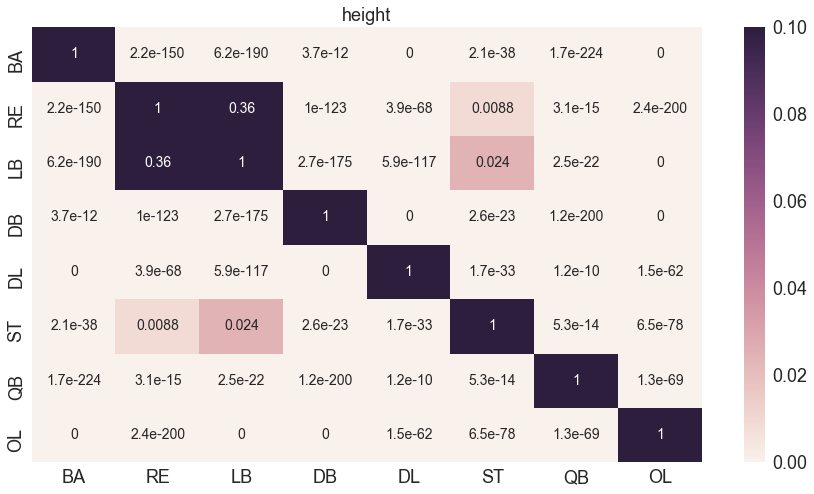

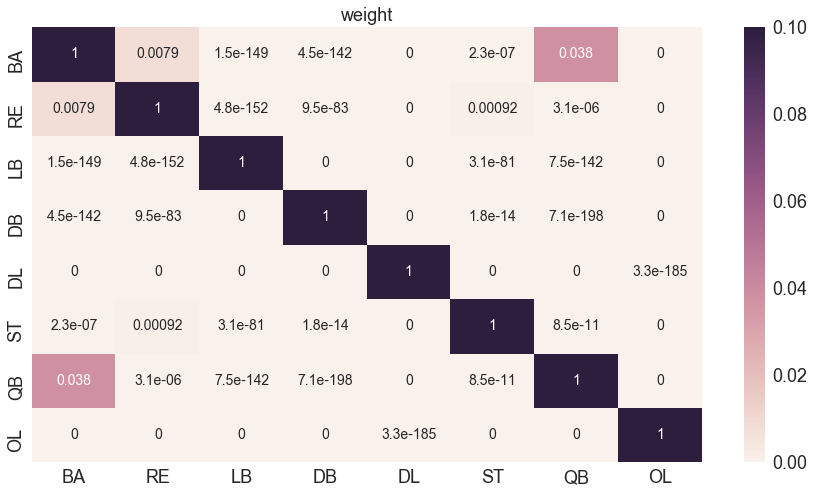

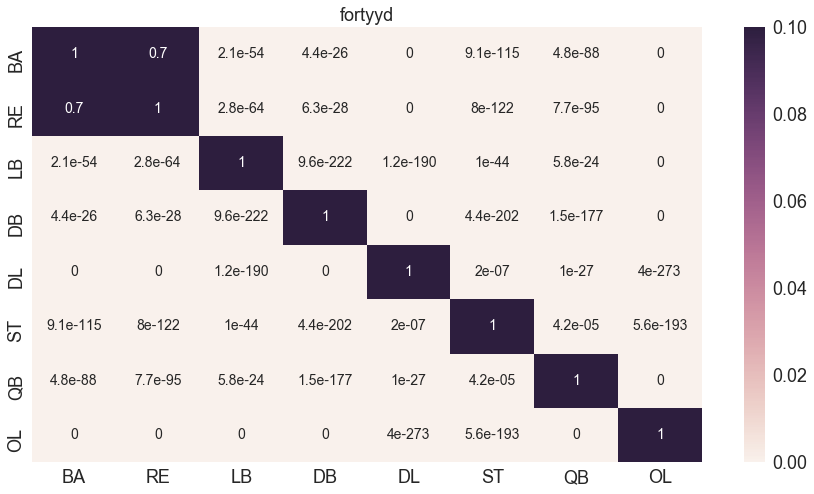

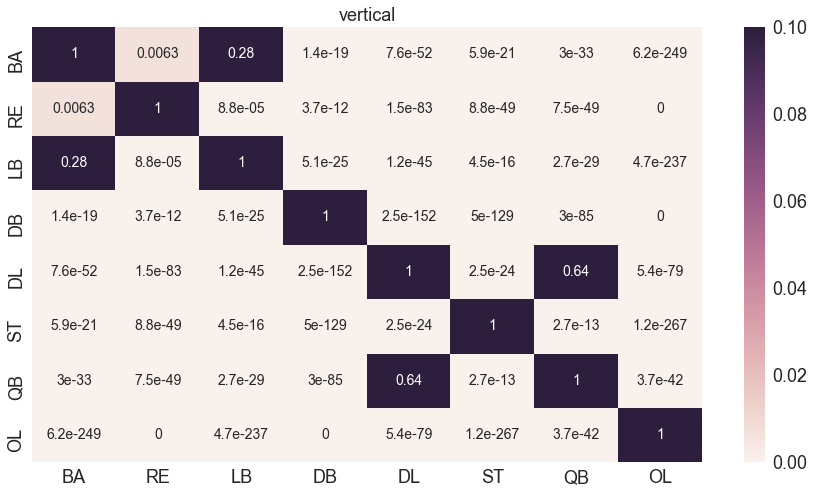

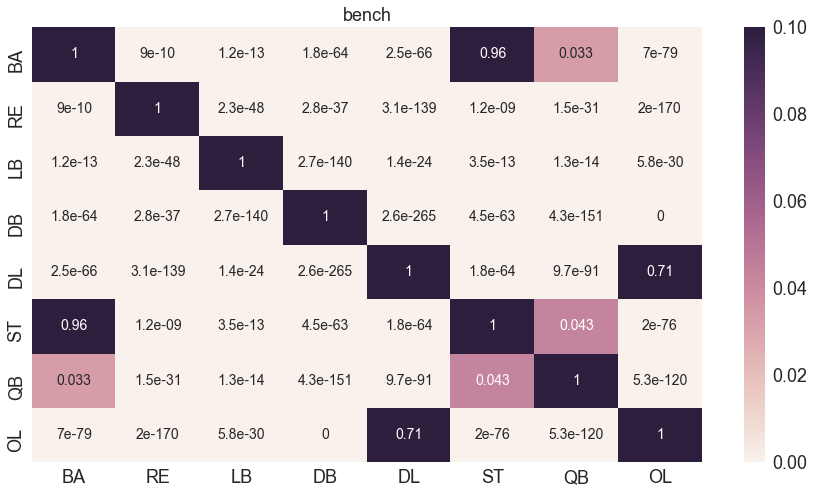

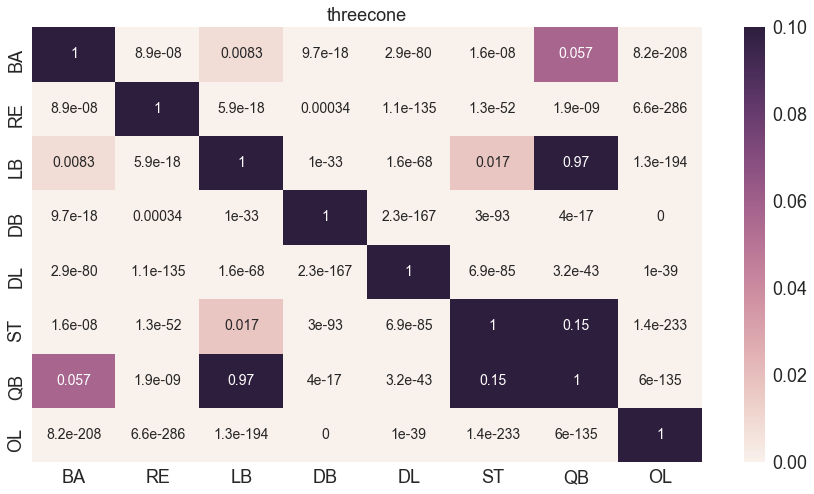

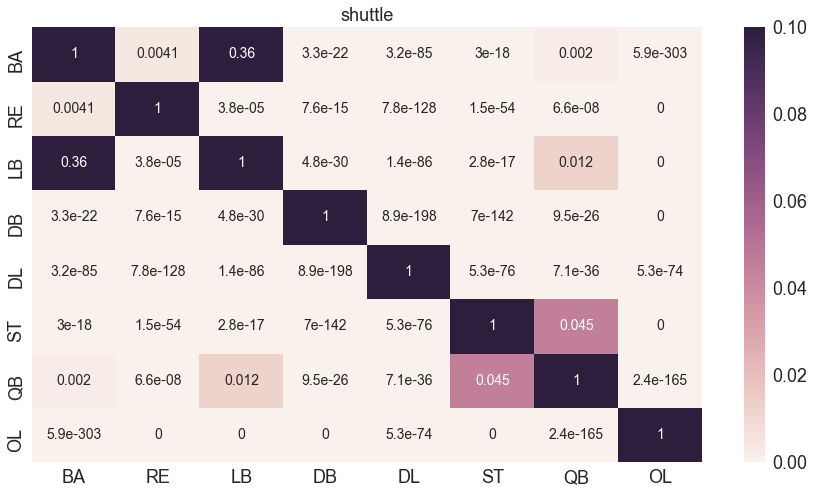

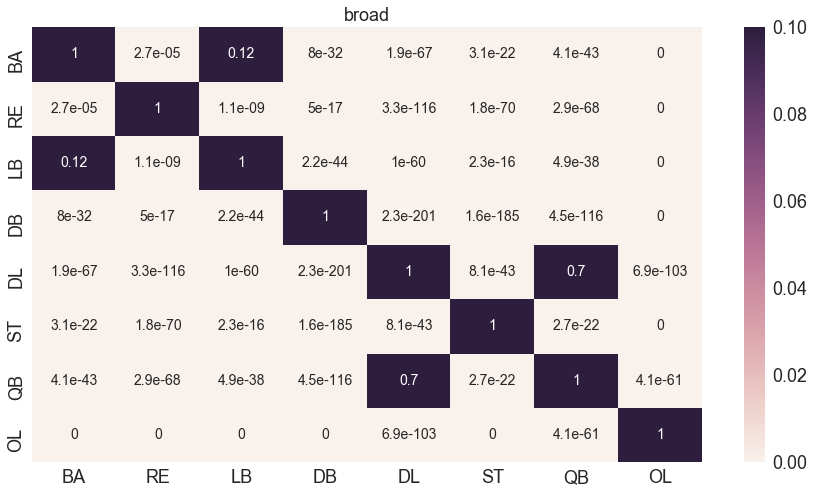

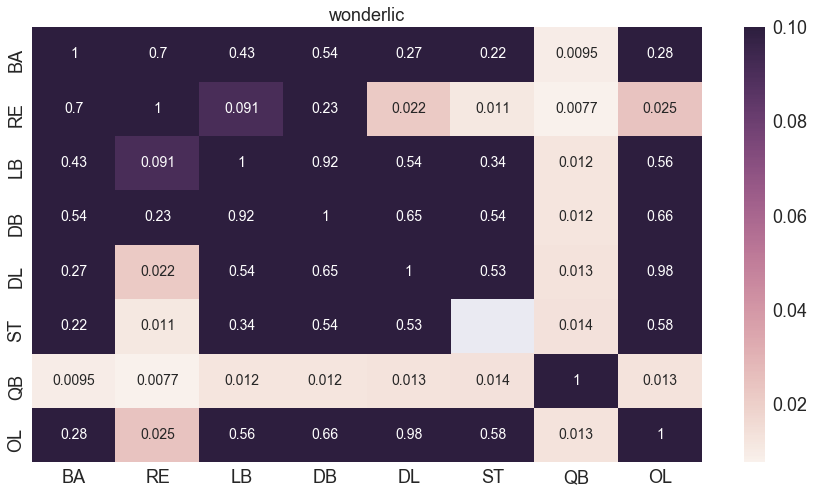

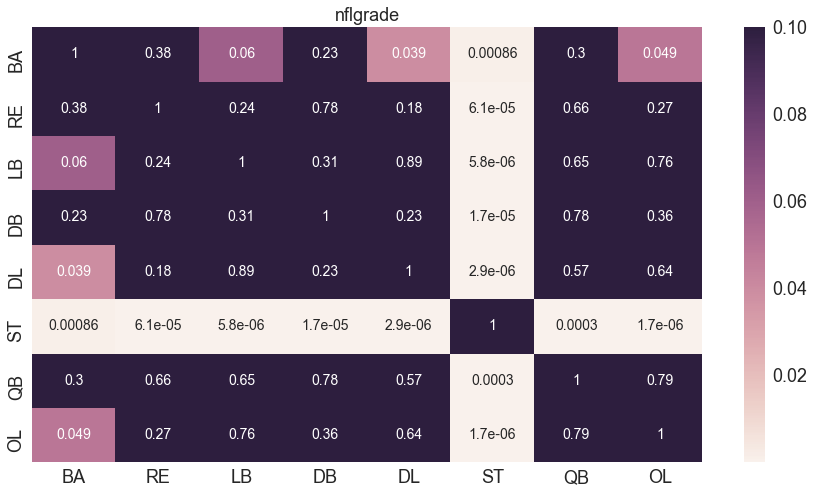

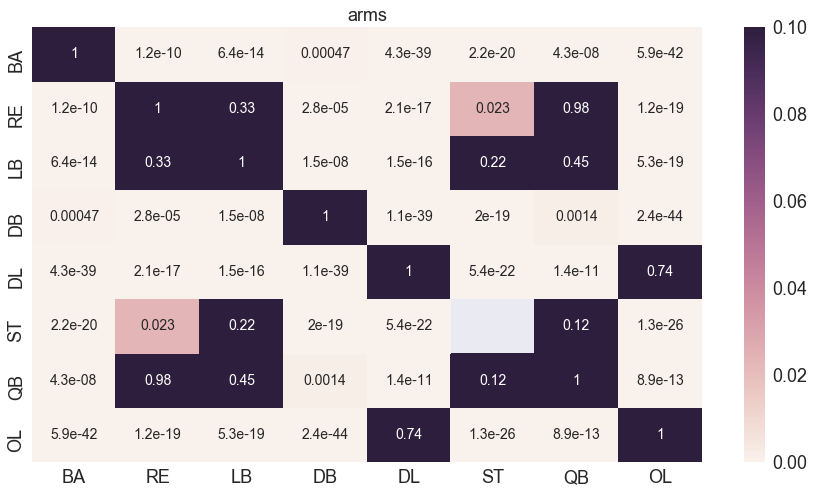

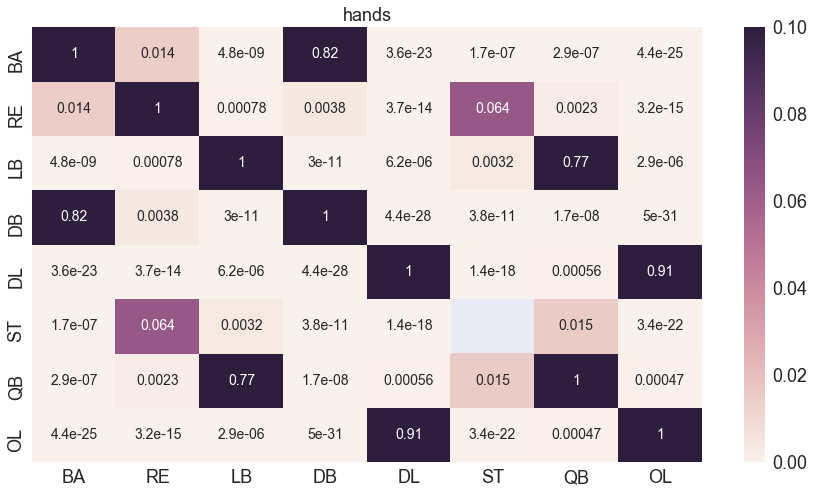

In [12]:
test_res = pd.DataFrame(index=df.positiongroup.unique(), columns=df.positiongroup.unique())
test_res.fillna(0)

#Loop through every column of interest for each positiongroup pair (brute-force)
for col in cols_to_view:
    for p1 in df.positiongroup.unique():
        for p2 in df.positiongroup.unique():
            
            #Get the relevant cols
            arr1 = df.loc[df.positiongroup==p1, col]
            arr2 = df.loc[df.positiongroup==p2, col]
            
            #Calculate z-test and CI
            res = sm.stats.CompareMeans(sm.stats.DescrStatsW(arr1), sm.stats.DescrStatsW(arr2))
            z_stat, zp_value = res.ztest_ind(usevar='unequal')
            z_lower, z_upper = res.zconfint_diff(alpha=0.05, usevar='unequal')
    
            #Construct dataframe with z-test results
            test_res.loc[p1, p2] = zp_value
    
    #Make heatmap of results for each col
    test_res = test_res.apply(pd.to_numeric)  
    sns.heatmap(test_res, vmax=0.1, annot=True, annot_kws={"size":14})
    plt.title("%s" % col)
    plt.show()    

There are lots of plots here, but we should be able to digest this pretty quickly. Again, dark colors means the null hypothesis cannot be rejected. The max color scale value was capped at 0.1 to ensure dark colors land outside the $\alpha$ level we have set. In general for all variables, the null hypothesis can be rejected. This implies there is a significant difference between the various **positiongroups**. This set of plots is good to look at since it gives reassurances that these different groups also have statistical differences. 

While some of the correlations are not as strong as we might have hoped, there are certainly indicators that the differences in the variables in the dataset are statistically different. This means there should be ways to leverage that infomation to make predictions about players. 

---------------

Et fin.